In [1]:
import torch
import torchvision

import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, RandomResizedCrop, RandomHorizontalFlip, Normalize
from torchvision.datasets import CIFAR10
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

In [ ]:
EPOCHS = 25

# Dataset load

In [ ]:
train_ds = CIFAR10("/cifar", train=True, download=True,\
                   transform=Compose([
                        ToTensor(),
                        RandomResizedCrop(size=32),
                        RandomHorizontalFlip(),
                        Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
                    ]))
test_ds = CIFAR10("/cifar", train=True, download=True,\
                  transform=Compose([
                        ToTensor(),
                        Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
                    ]))

# Utils

In [ ]:
def get_accuracy(model, test_dl):
    total = 0
    correct = 0

    with torch.no_grad():
        for data in test_dl:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = rn50(inputs)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

# Batch normalization

## Batch size

In [ ]:
df_batch = pd.DataFrame(columns=["acc", "batch_size"])

In [ ]:
loss_fn = nn.CrossEntropyLoss()

for batch_size in tqdm([128, 256, 512]):
    train_dl = DataLoader(train_ds, batch_size=batch_size, num_workers=2)
    test_dl = DataLoader(test_ds, batch_size=batch_size, num_workers=2)

    rn50 = torch.hub.load("pytorch/vision:v0.10.0", "resnet50", pretrained=False).to(device)
    optimizer = torch.optim.Adam(rn50.parameters())
    torch.manual_seed(20)
    
    for _ in range(EPOCHS):
        for data in train_dl:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = rn50(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            
    df_batch.loc[len(df_batch)] = [get_accuracy(rn50, test_dl), batch_size]

In [ ]:
df_batch.to_csv("batchsize_comp.csv")

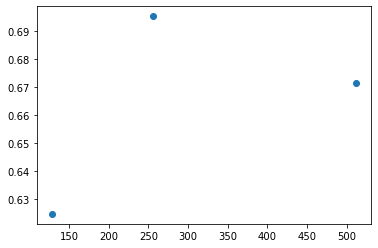

In [2]:
df_batch = pd.read_csv("batchsize_comp.csv")
plt.scatter(df_batch["batch_size"], df_batch["acc"])

## Optimizer

In [ ]:
best_batch_size =  256

train_dl = DataLoader(train_ds, batch_size=best_batch_size, num_workers=2)
test_dl = DataLoader(test_ds, batch_size=best_batch_size, num_workers=2)

In [ ]:
df_optim = pd.DataFrame(columns=["acc", "optim", "config"])

### Adam

In [ ]:
params = {
    "lr": [1e-2, 1e-3],
    "weight_decay": [1e-3, 1e-4, 1e-5]
}

In [ ]:
loss_fn = nn.CrossEntropyLoss()

for param in tqdm(ParameterGrid(params)):
    rn50 = torch.hub.load("pytorch/vision:v0.10.0", "resnet50", pretrained=False).to(device)
    optimizer = torch.optim.Adam(rn50.parameters(), lr=param["lr"], weight_decay=param["weight_decay"]) 
    torch.manual_seed(20)
    
    for _ in range(EPOCHS):
        for data in train_dl:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = rn50(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            
    df_optim.loc[len(df_optim)] = [get_accuracy(rn50, test_dl), "adam", str(param)]

### SGD

In [ ]:
params = {
    "lr": [1e-2, 1e-3],
    "weight_decay": [1e-3, 1e-4, 1e-5],
    "momentum": [0, 0.9]
}

In [ ]:
loss_fn = nn.CrossEntropyLoss()

for param in tqdm(ParameterGrid(params)):
    rn50 = torch.hub.load("pytorch/vision:v0.10.0", "resnet50", pretrained=False).to(device)
    optimizer = torch.optim.SGD(rn50.parameters(), lr=param["lr"], weight_decay=param["weight_decay"], momentum=param["momentum"])
    torch.manual_seed(20)
    
    for _ in range(EPOCHS):
        for data in train_dl:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = rn50(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            
    df_optim.loc[len(df_optim)] = [get_accuracy(rn50, test_dl), "sgd", str(param)]

In [ ]:
df_optim.to_csv("optim_comp.csv")

<AxesSubplot:xlabel='optim', ylabel='acc'>

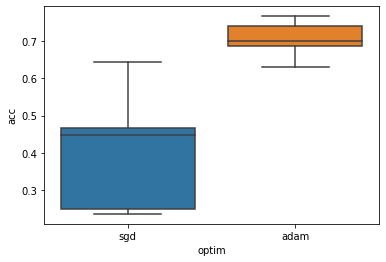

In [3]:
df_optim = pd.read_csv("optim_comp.csv")
sns.boxplot(x="optim", y="acc", data=df_optim)

## Scheduler

In [ ]:
best_lr =  # TODO
best_weight_decay =  # TODO
best_momentum =  # TODO if needed

In [ ]:
df_sched = pd.DataFrame(columns=["acc", "sched", "config"])

### OneCycleLR

In [ ]:
params = {
    "max_lr": [1e-2, 5e-3],
    "total_steps": [EPOCHS],
    "pct_start": [0.2, 0.3],
    "cycle_momentum": [],  # TODO [True, False] if SGD, [False] if adam
    "div_factor": [5, 10],
    "final_div_factor": [5, 10]
}

In [ ]:
loss_fn = nn.CrossEntropyLoss()

for param in tqdm(ParameterGrid(params)):
    rn50 = torch.hub.load("pytorch/vision:v0.10.0", "resnet50", pretrained=False).to(device)
    # TODO
#     optimizer = torch.optim.Adam(rn50.parameters(), lr=best_lr, weight_decay=best_weight_decay)
#     optimizer = torch.optim.SGD(rn50.parameters(), lr=best_lr, weight_decay=best_weight_decay, momentum=best_momentum)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=param["max_lr"], total_steps=param["total_steps"],
                                                   pct_start=param["pct_start"], cycle_momentum=param["cycle_momentum"],
                                                   div_factor=param["div_factor"], final_div_factor=param["final_div_factor"])
    torch.manual_seed(20)
    
    for _ in range(EPOCHS):
        for data in train_dl:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = rn50(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
        scheduler.step()
            
    df_sched.loc[len(df_sched)] = [get_accuracy(rn50, test_dl), "1clr", str(param)]

### ExponentialLR

In [ ]:
params = {
    "gamma": [0.95, 0.9]
}

In [ ]:
loss_fn = nn.CrossEntropyLoss()

for param in tqdm(ParameterGrid(params)):
    rn50 = torch.hub.load("pytorch/vision:v0.10.0", "resnet50", pretrained=False).to(device)
    # TODO
#     optimizer = torch.optim.Adam(rn50.parameters(), lr=best_lr, weight_decay=best_weight_decay)
#     optimizer = torch.optim.SGD(rn50.parameters(), lr=best_lr, weight_decay=best_weight_decay, momentum=best_momentum)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=param["gamma"])
    torch.manual_seed(20)
    
    for _ in range(EPOCHS):
        for data in train_dl:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = rn50(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
        scheduler.step()
            
    df_sched.loc[len(df_sched)] = [get_accuracy(rn50, test_dl), "exp", str(param)]

In [ ]:
df_sched.to_csv("sched_comp.csv")

In [ ]:
sns.boxplot(x="sched", y="acc", data=df_sched)

## Gradient clipping

In [ ]:
best_max_lr =  # TODO if needed
best_total_steps =  # TODO if needed
best_pct_start =  # TODO if needed
best_cycle_momentum =  # TODO if needed
best_div_factor =  # TODO if needed
best_final_div_factor =  # TODO if needed
best_gamma =  # TODO if needed

In [ ]:
df_clip = pd.DataFrame(columns=["acc", "clip_value"])

In [ ]:
loss_fn = nn.CrossEntropyLoss()

for clip_value in tqdm([1, 1e-1, 1e-3, 1e-4]):
    rn50 = torch.hub.load("pytorch/vision:v0.10.0", "resnet50", pretrained=False).to(device)
    # TODO
#     optimizer = torch.optim.Adam(rn50.parameters(), lr=best_lr, weight_decay=best_weight_decay)
#     optimizer = torch.optim.SGD(rn50.parameters(), lr=best_lr, weight_decay=best_weight_decay, momentum=best_momentum)
    
    # TODO
#     scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=best_max_lr, total_steps=best_total_steps,
#                                                    pct_start=best_pct_start, cycle_momentum=best_cycle_momentum,
#                                                    div_factor=best_div_factor, final_div_factor=best_final_div_factor)
#     scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=best_gamma)
    torch.manual_seed(20)
    
    for _ in range(EPOCHS):
        for data in train_dl:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = rn50(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            nn.utils.clip_grad_value_(rn50.parameters(), clip_value)
            optimizer.step()
        scheduler.step()
            
    df_clip.loc[len(df_clip)] = [get_accuracy(rn50, test_dl), clip_value]

In [ ]:
df_clip.to_csv("clip_com.csv")

In [ ]:
plt.scatter(df_clip["clip_value"], df_clip["acc"])
plt.xscale("log")